# Lab | QLoRA Tuning using PEFT from Hugging Face

<!-- ### Introduction to Quantization & Fine-tune a Quantized Model -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.

# Brief Introduction to Quantization
The main idea of quantization is simple: Reduce the precision of floating-point numbers, which normally occupy 32 bits, to integers of 8 or even 4 bits.

This reduction occurs in the model’s parameters, specifically in the weights of the neural layers, and in the activation values that flow through the model’s layers.

This means that we not only achieve an improvement in the model’s storage size and memory consumption but also greater agility in its calculations.

Naturally, there is a loss of precision, but particularly in the case of 8-bit quantization, this loss is minimal.



## Let's see a example of a quantized number.

In reality, what I want to examine is the precision loss that occurs when transitioning from a 32-bit number to a quantized 8/4-bit number and then returning to its original 32-bit value.

First, I'm going to create a function to quantize and another to unquantize.

In [1]:
#Importing necesary linbraries
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#Functions to quantize and unquantize
def quantize(value, bits=4):
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def unquantize(quantized_value, bits=4):
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)

Quatizied values:

In [3]:
quant_4 = quantize(0.622, 4)
print (quant_4)
quant_8 = quantize(0.622, 8)
print(quant_8)

4
79


Unquantized values:

In [4]:
unquant_4 = unquantize(quant_4, 4)
print(unquant_4)
unquant_8 = unquantize(quant_8, 8)
print(unquant_8)

0.5714285714285714
0.6220472440944882


If we consider that the original number was 0.622, it can be said that 8-bit quantization barely loses precision, and the loss from 4-bit quantization is manageable.

In [5]:
x = np.linspace(-1, 1, 50)
y = [math.cos(val) for val in x]


y_quant_8bit = np.array([quantize(val, bits=8) for val in y])
y_unquant_8bit = np.array([unquantize(val, bits=8) for val in y_quant_8bit])

y_quant_4bit = np.array([quantize(val, bits=4) for val in y])
y_unquant_4bit = np.array([unquantize(val, bits=4) for val in y_quant_4bit])


Let’s plot a curve with the unquantized values of a cosine.


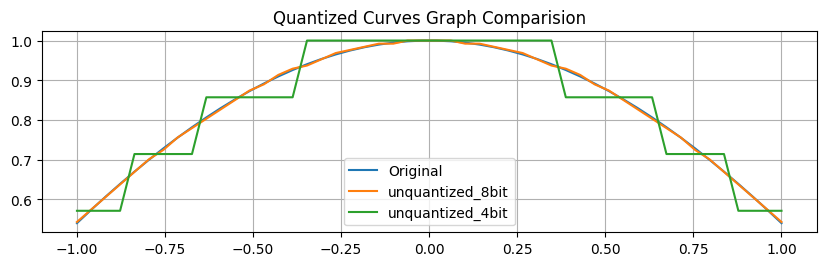

In [6]:
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.plot(x, y_unquant_8bit, label="unquantized_8bit")
plt.plot(x, y_unquant_4bit, label="unquantized_4bit")
plt.legend()
plt.title("Quantized Curves Graph Comparision")
plt.grid(True)

As you can see, the difference between the 8-bit and the original values is minimal. However, we need to use 4-bit quantization if we want to load the 7B Model into a 16GB GPU without problems.


# QLoRA. Fine-tuning a 4-bit Quantized Model using LoRA.
We are going to fine-tune with LoRA a 7B Model Quantizated to 4 bits.

## Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [7]:
!pip install -q bitsandbytes>=0.46.1

I'm going to download the peft and Transformers libraries from their repositories on GitHub instead of using pip. This is not strictly necessary, but this way, you can get the newest versions of the libraries with support for newer models. If you want to check one of the latest models, you can use this trick.


In [8]:
#Install the lastest versions of peft & transformers library recommended
#if you want to work with the most recent models
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install -q git+https://github.com/huggingface/trl.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


From the Transformers library, we import the necessary classes to load the model and the tokenizer.

The notebook is ready to work with different Models I tested it with models from the Bloom Family and Llama-3.

I recommend you to test different models.

## Hugging Face login

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

## Load Model

In [10]:
#Use any model you want, if you want to do some fast test, just use the smallest one.

#model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
#model_name = "bigscience/bloom-7b1"
#target_modules = ["query_key_value"]


model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Llama-family attention projection names
target_modules = ["q_proj", "v_proj"]


To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll achieve this with the BitesAndBytesConfig from the Transformers library.

In [11]:
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

We are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, I've used the recommended value in the paper [QLoRA: Efficient Finetuning of Quantized LLMs.](https://arxiv.org/abs/2305.14314)

Now, we can go ahead and load the model.

In [12]:
device_map = "auto"
foundation_model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=bnb_config,
                    device_map=device_map,
                    use_cache = False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Now we have the quantized version of the model in memory. Yo can try to load the unquantized version to see if it's possible.

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [14]:
import torch

# this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):  # PLAY WITH ARGS AS YOU SEE FIT
    model.eval()

    # --- Ensure inputs are on the same device as the model (prevents silent failures / echo) ---
    device = next(model.parameters()).device
    if isinstance(inputs, dict):
        inputs = {k: v.to(device) for k, v in inputs.items()}
    else:
        # If inputs isn't a dict for some reason, just try moving it
        inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask", None),
            max_new_tokens=max_new_tokens,

            # --- Better generation behavior ---
            do_sample=True,          # set False if you want deterministic comparisons
            temperature=0.7,
            top_p=0.9,

            repetition_penalty=1.5,  # Avoid repetition
            early_stopping=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,  # avoids warnings / bad padding behavior
        )

    return outputs


The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [15]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. I feel stuck and overwhelmed. Give me ONE next step that takes under 10 minutes, and explain why it works in one sentence.", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach. I feel stuck and overwhelmed. Give me ONE next step that takes under 10 minutes, and explain why it works in one sentence. For example: "Saying yes is the first small action towards taking control of your life."']


The answer is good enough, the models used is a really well trained Model. But we will try to improve the quality with a sort fine-tuning process.


## Preparing the Dataset.
The Dataset useds is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [16]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)

data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

del data
train_sample = train_sample.remove_columns('act')

display(train_sample)

README.md: 0.00B [00:00, ?B/s]

prompts.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1265 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2299 > 2048). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['prompt', 'for_devs', 'type', 'contributor', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [17]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'for_devs': [True], 'type': ['TEXT'], 'contributor': ['ameya-2003'], 'input_ids': [[1, 1954, 22094, 366, 526, 385, 18860, 382, 12711, 398, 13897, 3414, 287, 411, 4969, 263, 15040, 8078, 363, 263, 2908, 14153, 4473, 15109, 29889, 450, 12091, 338, 304, 4078, 7191, 373, 278, 2908, 14153, 29892, 3907, 963, 19909, 313, 3597, 29897, 304, 14332, 29892, 2044, 519, 313, 9053, 29897, 871, 304, 278, 2022, 1058, 2

## Fine-Tuning.
The first step will be to create a LoRA configuration object where we will set the variables that specify the characteristics of the fine-tuning process.

In [18]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16, #As bigger the R bigger the parameters to train.
    lora_alpha=16, # a scaling factor that adjusts the magnitude of the weight matrix. It seems that as higher more weight have the new training.
    target_modules=target_modules,
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="none", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the value more parameters are trained, but it means that the model will be able to learn more complicated relations between inputs and outputs.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_alpha**. Ad bigger the number more weight have the LoRA activations, it means that the fine-tuning process will have more impac as bigger is this value.

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

In [19]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [20]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments # , Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 2e-4, # Higher learning rate than full fine-tuning.
    num_train_epochs=5
)

Now we can train the model.
To train the model we need:


*   The Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.
* The LoRA config.





In [21]:
tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model=foundation_model,
    args=training_args,
    train_dataset=train_sample,
    peft_config = lora_config,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

Truncating train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Step,Training Loss


TrainOutput(global_step=35, training_loss=2.342829023088728, metrics={'train_runtime': 7.595, 'train_samples_per_second': 32.916, 'train_steps_per_second': 4.608, 'total_flos': 191420029452288.0, 'train_loss': 2.342829023088728})

In [22]:
import os
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

In [23]:
#Save the model.
trainer.model.save_pretrained(peft_model_path)

In [24]:
#In case you are having memory problems uncomment this lines to free some memory
import gc
import torch
#del foundation_model
#del trainer
#del train_sample
torch.cuda.empty_cache()
gc.collect()

853

## Inference with the pretrained model

In [25]:
#import peft
from peft import AutoPeftModelForCausalLM, PeftConfig
#import os

device_map = {"": 0}
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model")


In [29]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,  # stability
    bnb_4bit_use_double_quant=False        # stability
)

In [30]:
#Load the Model.
loaded_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    use_cache=False
)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

## Inference the fine-tuned model.

In [31]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach. 2) Be an advocate: You can help them by helping with their job search and networking efforts, provide advice on how they should prepare for interviews or meetings when seeking new jobs etc., this will give your client the confidence that he/']


The result is really good. Let's compare the answer of the pre-trained model with the fine-tuned one:

* **Pretrained Model**: 'I want you to act as a motivational coach. \xa0You are going on an adventure with me, and I need your help.\nWe will be traveling through the land of “What If.” \xa0 This is not some place that exists in reality; it’s more like one those places we see when watching'

* **Fine-Tuned Model**: 'I want you to act as a motivational coach.  I will provide some information about an individual or group of people who need motivation, and your role is help them find the inspiration they require in order achieve their goals successfully! You can use techniques such as positive reinforcement, visualization exercises etc., depending on what'

As you can see, the result is really similar to the samples contained in the dataset used to fine-tune the model. And we only trained the model for some epochs and with a really small number of rows.

 - Complete the prompts similar to what we did in class.
     - Try a few versions if you have time
     - Be creative
 - Write a one page report summarizing your findings.
     - Were there variations that didn't work well? i.e., where GPT either hallucinated or wrong
 - What did you learn?

In [32]:
import torch
from transformers import AutoModelForCausalLM

# -----------------------------
# 1) PROMPTS (baseline + creative)
# -----------------------------
prompts = [
    ("A_basic_role_only",
     "I want you to act as a motivational coach."),

    ("B_zoom_peptalk",
     "I want you to act as a motivational coach. I have 30 minutes before a Zoom call and I feel anxious. "
     "Give me a 60-second pep talk + 3 actions I can do right now."),

    ("C_7day_plan",
     "I want you to act as a motivational coach. Create a simple 7-day plan to build study consistency while working full-time. "
     "Keep it realistic and easy to follow."),

    ("D_reframe_failure",
     "I want you to act as a motivational coach. I failed my goal again. Reframe it kindly, then give me ONE next step that takes under 10 minutes."),

    ("E_calm_script",
     "I want you to act as a motivational coach. Give me a short script I can say to myself to calm anxiety before presenting. "
     "Then give 3 breathing or tension-release steps."),

    ("F_stop_overthinking",
     "I want you to act as a motivational coach. I’m stuck overthinking. Give me a 15-minute 'do this now' checklist and one rule to prevent spiraling.")
]

# -----------------------------
# 2) FIND/LOAD THE PRETRAINED BASE MODEL SAFELY
#    (handles cases where foundation_model was deleted)
# -----------------------------
def find_existing_base_model():
    # Common names used in labs
    for name in ["foundation_model", "base_model", "model", "original_model"]:
        if name in globals():
            obj = globals()[name]
            # Heuristic: transformers causal LM will have generate + config
            if hasattr(obj, "generate") and hasattr(obj, "config"):
                return obj, name
    return None, None

base_model, base_name = find_existing_base_model()

if base_model is None:
    # If base model was deleted, reload from model_name (string)
    if "model_name" not in globals() or not isinstance(model_name, str):
        raise NameError(
            "Could not find an existing base model object (foundation_model/base_model/model) "
            "and model_name (string) is not available to reload it."
        )

    print("Base model object not found in memory. Reloading from model_name...")
    # Use bnb_config/device_map if they exist in your notebook; else safe defaults
    load_kwargs = {}
    if "bnb_config" in globals():
        load_kwargs["quantization_config"] = bnb_config
    if "device_map" in globals():
        load_kwargs["device_map"] = device_map
    else:
        load_kwargs["device_map"] = "auto"

    base_model = AutoModelForCausalLM.from_pretrained(model_name, **load_kwargs)
    base_name = "reloaded_from_model_name"

print(f"Using base model: {base_name} -> {type(base_model)}")
print(f"Using tuned model: loaded_model -> {type(loaded_model)}")

# -----------------------------
# 3) GENERATION HELPERS (uses your lab's get_outputs)
# -----------------------------
def generate_text(model, prompt, max_new_tokens=120, device="cuda"):
    model.eval()

    # Tokenize and move to device
    inputs = tokenizer(prompt, return_tensors="pt")
    # Some notebooks use device_map="auto" (model shards), so pushing inputs to cuda is usually ok.
    # If you run into device mismatch, change .to("cuda") to .to(model.device) if available.
    inputs = inputs.to(device)

    with torch.no_grad():
        output_ids = get_outputs(model, inputs, max_new_tokens=max_new_tokens)

    return tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

def compare_models(base_model, tuned_model, prompts, max_new_tokens=120, device="cuda"):
    print("\n============================================================")
    print("MODEL COMPARISON: PRETRAINED (base) vs FINE-TUNED (PEFT)")
    print("============================================================\n")

    for tag, prompt in prompts:
        print("------------------------------------------------------------")
        print(f"PROMPT: {tag}")
        print("------------------------------------------------------------")
        print(prompt)

        print("\n[PRETRAINED OUTPUT]\n")
        try:
            print(generate_text(base_model, prompt, max_new_tokens=max_new_tokens, device=device))
        except Exception as e:
            print(f"(Error generating pretrained output: {e})")

        print("\n[FINE-TUNED OUTPUT]\n")
        try:
            print(generate_text(tuned_model, prompt, max_new_tokens=max_new_tokens, device=device))
        except Exception as e:
            print(f"(Error generating fine-tuned output: {e})")

        print("\n")

# -----------------------------
# 4) RUN COMPARISON
# -----------------------------
compare_models(
    base_model=base_model,
    tuned_model=loaded_model,
    prompts=prompts,
    max_new_tokens=120,
    device="cuda"
)



Using base model: foundation_model -> <class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>
Using tuned model: loaded_model -> <class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>

MODEL COMPARISON: PRETRAINED (base) vs FINE-TUNED (PEFT)

------------------------------------------------------------
PROMPT: A_basic_role_only
------------------------------------------------------------
I want you to act as a motivational coach.

[PRETRAINED OUTPUT]

I want you to act as a motivational coach. You will be assigned clients who are struggling with self-esteem, low confidence or lack of direction in their life. Based on the passage above: Can you summarize what role Kyle McIntyre plays during his time at The Motivation Project and how he hopes to help those undergoing personal growth?

[FINE-TUNED OUTPUT]

I want you to act as a motivational coach.
You are the one who can inspire and encourage me, guide my journey forward with all your wisdom!


------------------

**Verdict**: Both the pretrained and fine-tuned outputs are messy. LoRA shifts the model’s behaviour slightly, but it’s not enough on its own—clearer prompts and more context are still needed. Next, we’ll test that by using more structured prompts.

In [33]:
import torch

# 1) Cleaner prompts (more constrained = easier to evaluate)
better_prompts = [
    ("B1_zoom_coach_structured",
     "You are a motivational coach. Respond ONLY with:\n"
     "1) A 2-sentence pep talk\n"
     "2) Exactly 3 bullet actions\n"
     "No other text.\n\n"
     "Situation: I have a Zoom call in 30 minutes and feel anxious."),

    ("B2_7day_plan_numbered",
     "You are a motivational coach. Create a realistic 7-day study consistency plan.\n"
     "Rules:\n"
     "- Output ONLY a numbered list from 1 to 7\n"
     "- Each day must be one sentence\n"
     "- Each sentence must include a time limit (e.g., 20 minutes)\n\n"
     "Context: I work full-time and study AI engineering."),

    ("B3_stop_overthinking_15min",
     "You are a motivational coach.\n"
     "Give me a 15-minute 'do this now' checklist.\n"
     "Rules:\n"
     "- Output ONLY bullet points\n"
     "- Exactly 5 bullets\n"
     "- End with ONE short rule (max 12 words) on a new line starting with 'Rule:'")
]

def clean_generate(model, prompt, max_new_tokens=120):
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt")
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        gen_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,                 # deterministic output (clean comparisons)
            repetition_penalty=1.2,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode ONLY the generated continuation (not the prompt)
    input_len = inputs["input_ids"].shape[-1]
    new_tokens = gen_ids[0][input_len:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

def clean_compare(foundation_model, loaded_model, prompts, max_new_tokens=120):
    print("============================================================")
    print("CLEAN EVALUATION: deterministic + decode new tokens only")
    print("============================================================\n")

    for tag, prompt in prompts:
        print("------------------------------------------------------------")
        print(f"PROMPT: {tag}")
        print("------------------------------------------------------------")
        print(prompt)

        print("\n[PRETRAINED OUTPUT - CLEAN]\n")
        try:
            print(clean_generate(foundation_model, prompt, max_new_tokens=max_new_tokens))
        except Exception as e:
            print(f"(Error: {e})")

        print("\n[FINE-TUNED OUTPUT - CLEAN]\n")
        try:
            print(clean_generate(loaded_model, prompt, max_new_tokens=max_new_tokens))
        except Exception as e:
            print(f"(Error: {e})")

        print("\n")

# Run clean evaluation right below your "weirdness" cell
clean_compare(foundation_model, loaded_model, better_prompts, max_new_tokens=160)


CLEAN EVALUATION: deterministic + decode new tokens only

------------------------------------------------------------
PROMPT: B1_zoom_coach_structured
------------------------------------------------------------
You are a motivational coach. Respond ONLY with:
1) A 2-sentence pep talk
2) Exactly 3 bullet actions
No other text.

Situation: I have a Zoom call in 30 minutes and feel anxious.

[PRETRAINED OUTPUT - CLEAN]

Can you provide me with some tips on how to calm myself down?

[FINE-TUNED OUTPUT - CLEAN]

Can you provide me with some actionable tips to help me stay focused?


------------------------------------------------------------
PROMPT: B2_7day_plan_numbered
------------------------------------------------------------
You are a motivational coach. Create a realistic 7-day study consistency plan.
Rules:
- Output ONLY a numbered list from 1 to 7
- Each day must be one sentence
- Each sentence must include a time limit (e.g., 20 minutes)

Context: I work full-time and study AI 

**Final detailed verdict**.

After switching to deterministic generation (do_sample=False) and decoding only the newly generated tokens, the outputs became stable and comparable (no longer just echoing the prompt).

Both models still struggled with instruction-following, especially strict formatting constraints.

B1 (2 sentences + 3 bullets): both models responded with a question instead of delivering the required pep talk + actions.

B2 (numbered 1–7, one sentence each + time limits): both produced multi-line schedules that didn’t match the required format and cut off mid-plan.

B3 (exactly 5 bullets + “Rule:” line): base produced too many bullets; tuned produced too few bullets and omitted the final “Rule:” line.

The key learning: prompt constraints + evaluation settings matter, and fine-tuning does not guarantee perfect constraint compliance. The clean evaluation method made failure modes clear: both models can generate relevant-looking text, but they are unreliable at following strict output rules.